# Battery operation with limited foresight

An electric utility company has invested in a 200 MW wind farm, including a 20 MW battery storage system at their facilities. The facility has a constant demand of 25 MW. The company can also obtain power from the grid at 150 €/MWh. Given the available information, the electric utility company wants to find an optimal operational schedule for three days in March. Assume that feeding electricity into the grid is not permitted.

# Initialise System with PyPSA
We start by modelling the electric utility company as a single node, with the load attached. The grid electricity is modelled as a generator with marginal cost of 150 €/MWh and a capacity of 30 MW.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pypsa


n = pypsa.Network()
n.add("Bus", "company")
n.add("Load", "demand", bus="company", p_set=25, carrier="load")
n.add("Generator", "grid", bus="company", p_nom=30, marginal_cost=150, carrier="grid")

Index(['grid'], dtype='object')

Next, we read in the capacity factor time series for onshore wind, which covers hourly data from 2011. We are interested in the period from 1st to 4th March. The capacity factors indicate relatively high wind availability on the 1st and 2nd of March, which decreases towards the end of the period.

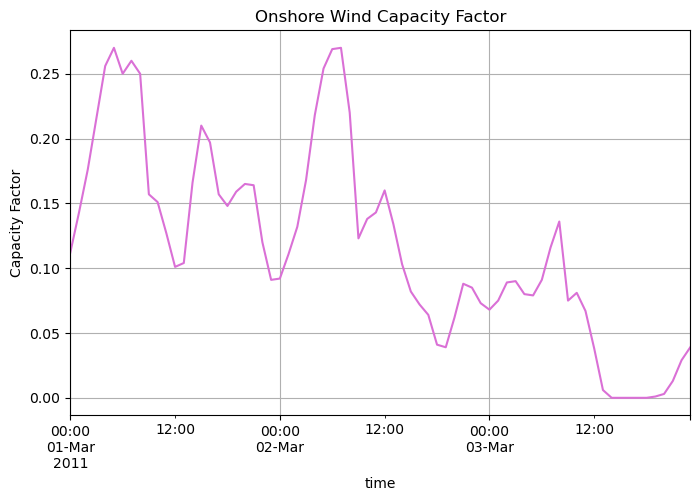

In [2]:
p_max_pu = pd.read_csv(
    "https://model.energy/data/time-series-f17c3736a2719ce7da58484180d89e2d.csv",
    index_col=0,
    parse_dates=True,
)["onwind"]

start_date = '2011-03-01 00:00:00'  
end_date = '2011-03-03 23:00:00'   

p_max_pu_select = p_max_pu[start_date:end_date]
p_max_pu_select.plot(title="Onshore Wind Capacity Factor", color="orchid", ylabel="Capacity Factor", grid=True, figsize=(8, 5))
plt.show()

Next, we need to tell PyPSA that theses are the snapshots (time steps) we want to optimize over. 

In [3]:
n.set_snapshots(p_max_pu_select.index)

Now, we add the wind farm with the availability time series as p_max_pu, and the capacity of 200 MW as p_nom. Then, we also add the battery storage with a dispatch capacity of 20 MW, a charge and discharge efficiency of 95% and an energy-to-power ratio of 8 hours.

In [4]:
n.add(
    "Generator",
    "onwind",
    bus="company",
    p_max_pu=p_max_pu_select,
    p_nom=200,
    carrier="onwind",
)

n.add(
    "StorageUnit",
    "battery",
    bus="company",
    p_nom=20,
    carrier="battery",
    efficiency_store=0.95,
    efficiency_dispatch=0.95,
    max_hours=8,
)

Index(['battery'], dtype='object')

Now, we have received our initialised PyPSA network. In order to compare it to a system solved with rolling horizon after optimisation, we must copy the network beforehand.

In [5]:
m = n.copy()

As a first step, we solve the network optimization over the entire period under the assumption of perfect foresight. This standard approach presumes complete knowledge of future conditions, including weather patterns, battery operation, and load development.

In [6]:
n.optimize(log_to_console=False)

Index(['demand'], dtype='object', name='Load')
Index(['grid', 'onwind'], dtype='object', name='Generator')
Index(['company'], dtype='object', name='Bus')
Index(['battery'], dtype='object', name='StorageUnit')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - log_to_console: False
INFO:linopy.io: Writing time: 0.02s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 360 primals, 864 duals
Objective: 4.86e+04
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Running HiGHS 1.11.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms


('ok', 'optimal')

In a second step, we apply a rolling-horizon optimization to simulate limited foresight. Instead of optimizing over the entire period at once, the model solves shorter time windows sequentially, using only information available up to the current horizon. This approach better reflects real-world conditions, where future developments in weather, load, and storage behavior are uncertain. By updating the optimization as new information becomes available, the model captures more realistic operational decisions under uncertainty.

We assume that wind capacity factor forecasts are available only 24 hours into the future (horizon=24) and the forecast of the next 24 hours only comes available after 24 hours (overlap=0). Note that we use the real capacity factors as the forecasts and therefore do not consider forecast errors in this case.

In [7]:
n_rh_24_0 = m.copy()
n_rh_24_0.optimize.optimize_with_rolling_horizon(horizon=24, overlap=0, log_to_console=False)

INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2011-03-01 00:00:00:2011-03-01 23:00:00] (1/3).
Index(['demand'], dtype='object', name='Load')
Index(['grid', 'onwind'], dtype='object', name='Generator')
Index(['company'], dtype='object', name='Bus')
Index(['battery'], dtype='object', name='StorageUnit')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - log_to_console: False
INFO:linopy.io: Writing time: 0.02s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 120 primals, 288 duals
Objective: 3.90e+02
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, Stora

Running HiGHS 1.11.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - log_to_console: False
INFO:linopy.io: Writing time: 0.02s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 120 primals, 288 duals
Objective: 1.41e+03
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2011-03-03 00:00:00:2011-03-03 23:00:00] (3/3).
Index(['demand'], dtype='object', name='Load')
Index(['grid', 'onwind'], dtype='object', name='Generator')
Index(['company'], dtype='object', name='Bus')

Running HiGHS 1.11.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - log_to_console: False
INFO:linopy.io: Writing time: 0.02s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 120 primals, 288 duals
Objective: 5.48e+04
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Running HiGHS 1.11.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms


PyPSA Network 'Unnamed Network'
-------------------------------
Components:
 - Bus: 1
 - Generator: 2
 - Load: 1
 - StorageUnit: 1
Snapshots: 72

We can now compare electricity supply between the two systems. Under perfect foresight, the model is able to integrate a higher share of wind generation, as it optimally coordinates storage and dispatch decisions based on full knowledge of future conditions. In contrast, the limited foresight model—lacking information about future wind availability—tends to deplete storage more conservatively or prematurely, resulting in less efficient use of wind energy.


In [8]:
supply_comparison = pd.concat(
    [n.statistics.supply(), n_rh_24_0.statistics.supply()],
    axis=1
).round(2)
supply_comparison.columns = ["Perfect Foresight", "Rolling Horizon"]
supply_comparison

Perfect Foresight  Rolling Horizon
component   carrier                                    
Generator   grid                323.81           377.01
            onwind             1495.69          1436.75
StorageUnit battery             180.59           127.39

A comparison of the battery state of charge in both systems reveals the underlying cause. The system with perfect foresight anticipates upcoming drops in wind availability and therefore charges the battery fully during periods of high wind generation. This enables it to supply low-cost wind electricity to the system over a longer period. In contrast, the limited foresight model cannot anticipate the decline in wind availability and thus discharges completely after 24 hours. Threfore it is not able to keep the battery SOC as high as in the perfect foresight case.

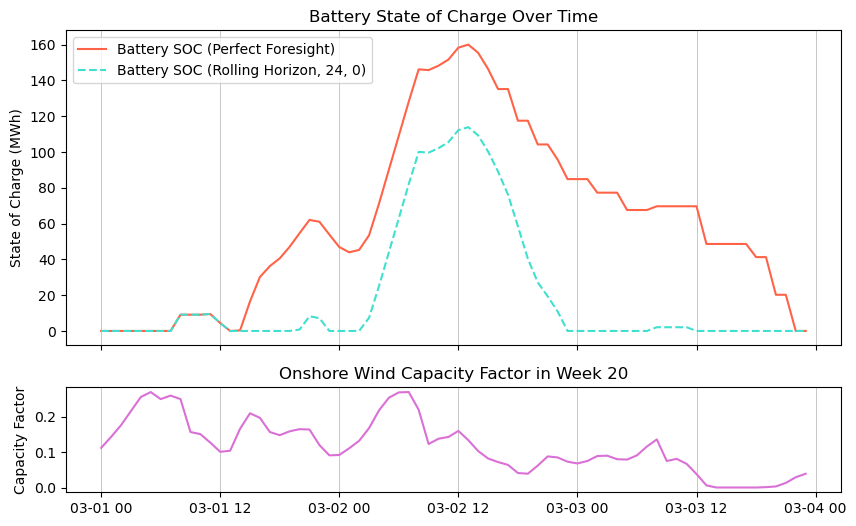

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), height_ratios=[3, 1], sharex=True)

# Top subplot - Battery SOC
ax1.plot(n.snapshots, n.storage_units_t.state_of_charge.loc[n.snapshots],
         label="Battery SOC (Perfect Foresight)", color="tomato")
ax1.plot(n_rh_24_0.snapshots, n_rh_24_0.storage_units_t.state_of_charge.loc[n_rh_24_0.snapshots],
         label="Battery SOC (Rolling Horizon, 24, 0)", color="turquoise", ls="--")
ax1.set_ylabel("State of Charge (MWh)")
ax1.grid(axis='x', linestyle="-", linewidth=0.5)
ax1.set_title("Battery State of Charge Over Time")
ax1.legend(loc="upper left")

# Bottom subplot - Wind Capacity Factor
ax2.plot(p_max_pu_select.index, p_max_pu_select.values,
         color="orchid")
ax2.set_ylabel("Capacity Factor")
ax2.set_title("Onshore Wind Capacity Factor in Week 20")
ax2.grid(axis='x', linestyle="-", linewidth=0.5)

If we look at the energy balance, we can see where the perfect foresight model manages to utilize the battery better to maximise the cheap wind energy generation. The onwind generation in the second half of 1st March is not utilized by the rolling horizon model. As a result the grid has to privide more electricity on 3rd of March. 

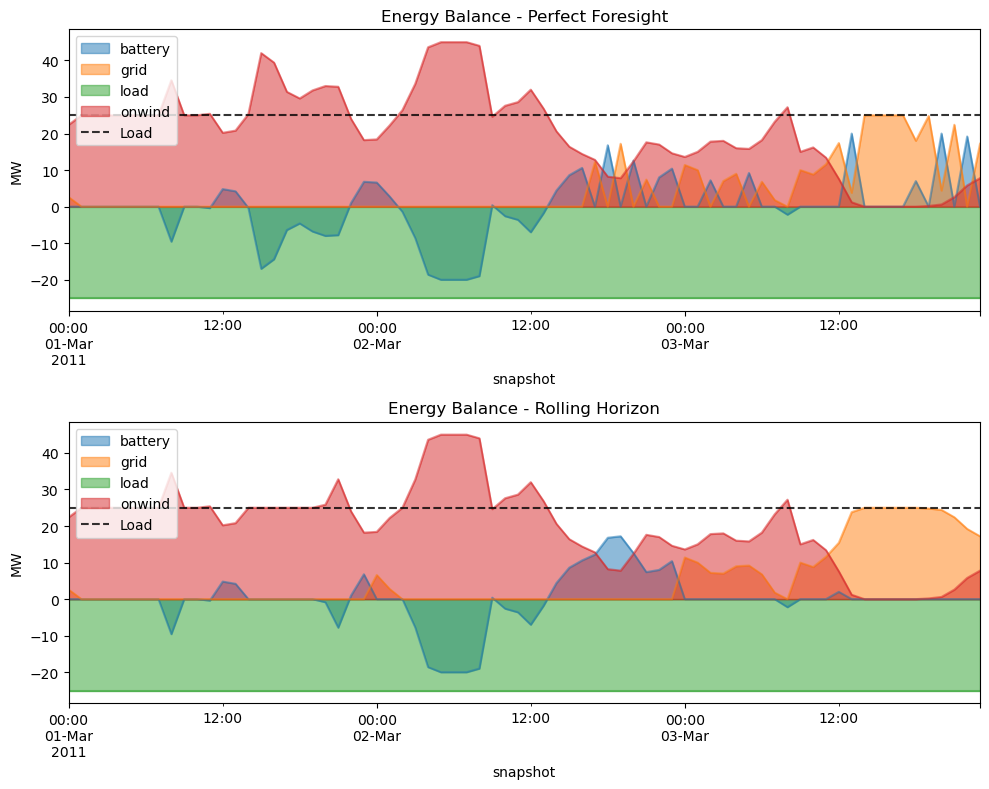

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Top subplot - Perfect Foresight Network
n.statistics.energy_balance(aggregate_time=False).droplevel(0).groupby("carrier").sum().T.plot(
    kind='area',
    stacked=False,
    alpha=0.5,
    ax=ax1,
    title="Energy Balance - Perfect Foresight"
)
ax1.axhline(y=25, color='black', linestyle='--', alpha=0.8, label='Load')
ax1.set_ylabel('MW')
ax1.legend(loc="upper left")

# Bottom subplot - Rolling Horizon Network  
n_rh_24_0.statistics.energy_balance(aggregate_time=False).droplevel(0).groupby("carrier").sum().T.plot(
    kind='area',
    stacked=False,
    alpha=0.5,
    ax=ax2,
    title="Energy Balance - Rolling Horizon"
)
ax2.axhline(y=25, color='black', linestyle='--', alpha=0.8, label='Load')
ax2.set_ylabel('MW')
ax2.legend(loc="upper left")
plt.tight_layout()
plt.show()

To ensure temporal consistency between consecutive optimization windows, we can introduce an overlap. This overlap mitigates boundary effects, such as the model’s tendency to deplete storage assets at the end of each forecast horizon, which can otherwise result from myopic decision-making. 

To investigate more realistic scenarios, we can for example use a 24 hours forecast horizon with a forecast update frequency of 22 hours. If the forecast update frequency is shorter than the horizon lengh, there is an overlap of the rolling horizons.

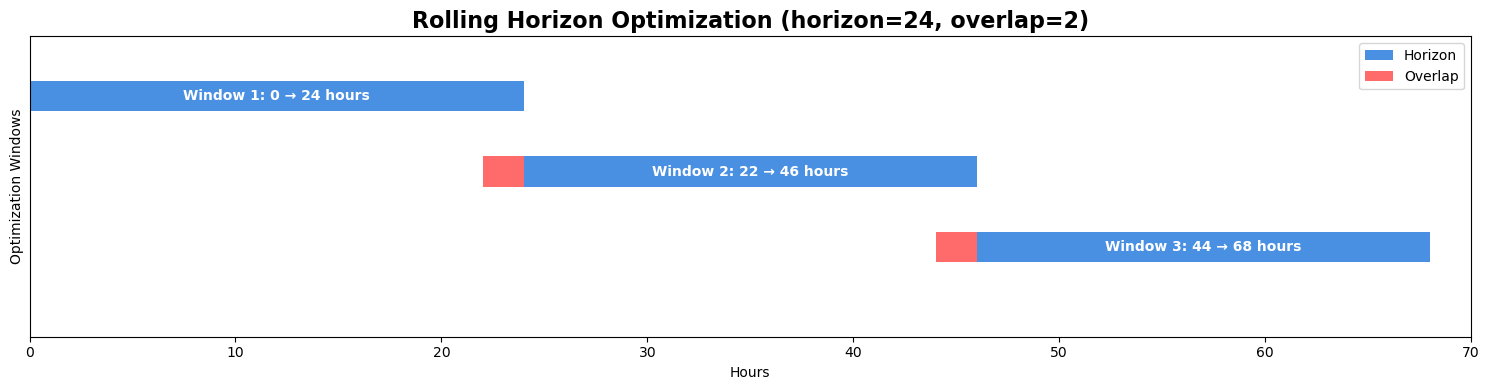

We now investigate which effects different forecast horizon and overlap values have on the optimization. Therefore we first define different horizon-overlap pairs and then solve them.

In [11]:
# Define your horizon-overlap pairs
configs = [(12, 0), (24, 2), (28, 4), (36, 12), (48, 24)]
scenario_names = ["Perfect Foresight"] + ["RH (24,0)"] + [f"RH ({h},{o})" for h, o in configs]
scenario_colors = ["tomato", "indigo", "turquoise", "orange", "green", "olive", "gold"]

In [12]:
# Store results in a dictionary
results = {}
results["Perfect Foresight"] = n
results["RH (24,0)"] = n_rh_24_0

for h, o in configs:
    name = f"RH ({h},{o})"
    print(f"Running optimization for {name}...")
    net = m.copy()
    net.optimize.optimize_with_rolling_horizon(
        horizon=h,
        overlap=o,
        log_to_console=False
    )
    results[name] = net

INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2011-03-01 00:00:00:2011-03-01 11:00:00] (1/6).
Index(['demand'], dtype='object', name='Load')
Index(['grid', 'onwind'], dtype='object', name='Generator')
Index(['company'], dtype='object', name='Bus')
Index(['battery'], dtype='object', name='StorageUnit')


Running optimization for RH (12,0)...


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - log_to_console: False
INFO:linopy.io: Writing time: 0.02s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 60 primals, 144 duals
Objective: 3.90e+02
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2011-03-01 12:00:00:2011-03-01 23:00:00] (2/6).
Index(['demand'], dtype='object', name='Load')
Index(['grid', 'onwind'], dtype='object', name='Generator')
Index(['company'], dtype='object', name='Bus')


Running HiGHS 1.11.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - log_to_console: False
INFO:linopy.io: Writing time: 0.02s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 60 primals, 144 duals
Objective: 1.35e+03
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2011-03-02 00:00:00:2011-03-02 11:00:00] (3/6).
Index(['demand'], dtype='object', name='Load')
Index(['grid', 'onwind'], dtype='object', name='Generator')
Index(['company'], dtype='object', name='Bus')


Running HiGHS 1.11.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - log_to_console: False
INFO:linopy.io: Writing time: 0.02s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 60 primals, 144 duals
Objective: 1.41e+03
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2011-03-02 12:00:00:2011-03-02 23:00:00] (4/6).
Index(['demand'], dtype='object', name='Load')
Index(['grid', 'onwind'], dtype='object', name='Generator')
Index(['company'], dtype='object', name='Bus')


Running HiGHS 1.11.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - log_to_console: False
INFO:linopy.io: Writing time: 0.02s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 60 primals, 144 duals
Objective: 1.50e+04
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2011-03-03 00:00:00:2011-03-03 11:00:00] (5/6).
Index(['demand'], dtype='object', name='Load')
Index(['grid', 'onwind'], dtype='object', name='Generator')
Index(['company'], dtype='object', name='Bus')


Running HiGHS 1.11.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - log_to_console: False
INFO:linopy.io: Writing time: 0.02s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 60 primals, 144 duals
Objective: 1.36e+04
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2011-03-03 12:00:00:2011-03-03 23:00:00] (6/6).
Index(['demand'], dtype='object', name='Load')
Index(['grid', 'onwind'], dtype='object', name='Generator')
Index(['company'], dtype='object', name='Bus')


Running HiGHS 1.11.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - log_to_console: False
INFO:linopy.io: Writing time: 0.02s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 60 primals, 144 duals
Objective: 4.11e+04
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2011-03-01 00:00:00:2011-03-01 23:00:00] (1/4).
Index(['demand'], dtype='object', name='Load')
Index(['grid', 'onwind'], dtype='object', name='Generator')
Index(['company'], dtype='object', name='Bus')


Running HiGHS 1.11.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
Running optimization for RH (24,2)...


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - log_to_console: False
INFO:linopy.io: Writing time: 0.02s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 120 primals, 288 duals
Objective: 3.90e+02
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2011-03-01 22:00:00:2011-03-02 21:00:00] (2/4).
Index(['demand'], dtype='object', name='Load')
Index(['grid', 'onwind'], dtype='object', name='Generator')
Index(['company'], dtype='object', name='Bus')

Running HiGHS 1.11.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - log_to_console: False
INFO:linopy.io: Writing time: 0.02s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 120 primals, 288 duals
Objective: 1.41e+03
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2011-03-02 20:00:00:2011-03-03 19:00:00] (3/4).
Index(['demand'], dtype='object', name='Load')
Index(['grid', 'onwind'], dtype='object', name='Generator')
Index(['company'], dtype='object', name='Bus')

Running HiGHS 1.11.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - log_to_console: False
INFO:linopy.io: Writing time: 0.02s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 120 primals, 288 duals
Objective: 4.50e+04
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2011-03-03 18:00:00:2011-03-03 23:00:00] (4/4).
Index(['demand'], dtype='object', name='Load')
Index(['grid', 'onwind'], dtype='object', name='Generator')
Index(['company'], dtype='object', name='Bus')

Running HiGHS 1.11.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - log_to_console: False
INFO:linopy.io: Writing time: 0.02s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 30 primals, 72 duals
Objective: 2.00e+04
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2011-03-01 00:00:00:2011-03-02 03:00:00] (1/3).
Index(['demand'], dtype='object', name='Load')
Index(['grid', 'onwind'], dtype='object', name='Generator')
Index(['company'], dtype='object', name='Bus')
I

Running HiGHS 1.11.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
Running optimization for RH (28,4)...


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - log_to_console: False
INFO:linopy.io: Writing time: 0.02s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140 primals, 336 duals
Objective: 3.90e+02
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2011-03-02 00:00:00:2011-03-03 03:00:00] (2/3).
Index(['demand'], dtype='object', name='Load')
Index(['grid', 'onwind'], dtype='object', name='Generator')
Index(['company'], dtype='object', name='Bus')

Running HiGHS 1.11.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - log_to_console: False
INFO:linopy.io: Writing time: 0.02s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140 primals, 336 duals
Objective: 5.03e+03
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2011-03-03 00:00:00:2011-03-03 23:00:00] (3/3).
Index(['demand'], dtype='object', name='Load')
Index(['grid', 'onwind'], dtype='object', name='Generator')
Index(['company'], dtype='object', name='Bus')

Running HiGHS 1.11.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - log_to_console: False
INFO:linopy.io: Writing time: 0.02s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 120 primals, 288 duals
Objective: 5.11e+04
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2011-03-01 00:00:00:2011-03-02 11:00:00] (1/3).
Index(['demand'], dtype='object', name='Load')
Index(['grid', 'onwind'], dtype='object', name='Generator')
Index(['company'], dtype='object', name='Bus')

Running HiGHS 1.11.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
Running optimization for RH (36,12)...


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - log_to_console: False
INFO:linopy.io: Writing time: 0.02s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 180 primals, 432 duals
Objective: 3.90e+02
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2011-03-02 00:00:00:2011-03-03 11:00:00] (2/3).
Index(['demand'], dtype='object', name='Load')
Index(['grid', 'onwind'], dtype='object', name='Generator')
Index(['company'], dtype='object', name='Bus')

Running HiGHS 1.11.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - log_to_console: False
INFO:linopy.io: Writing time: 0.02s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 180 primals, 432 duals
Objective: 1.33e+04
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2011-03-03 00:00:00:2011-03-03 23:00:00] (3/3).
Index(['demand'], dtype='object', name='Load')
Index(['grid', 'onwind'], dtype='object', name='Generator')
Index(['company'], dtype='object', name='Bus')

Running HiGHS 1.11.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - log_to_console: False
INFO:linopy.io: Writing time: 0.02s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 120 primals, 288 duals
Objective: 4.68e+04
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2011-03-01 00:00:00:2011-03-02 23:00:00] (1/3).
Index(['demand'], dtype='object', name='Load')
Index(['grid', 'onwind'], dtype='object', name='Generator')
Index(['company'], dtype='object', name='Bus')

Running HiGHS 1.11.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
Running optimization for RH (48,24)...


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - log_to_console: False
INFO:linopy.io: Writing time: 0.02s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 240 primals, 576 duals
Objective: 3.90e+02
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2011-03-02 00:00:00:2011-03-03 23:00:00] (2/3).
Index(['demand'], dtype='object', name='Load')
Index(['grid', 'onwind'], dtype='object', name='Generator')
Index(['company'], dtype='object', name='Bus')

Running HiGHS 1.11.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - log_to_console: False
INFO:linopy.io: Writing time: 0.02s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 240 primals, 576 duals
Objective: 5.44e+04
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2011-03-03 00:00:00:2011-03-03 23:00:00] (3/3).
Index(['demand'], dtype='object', name='Load')
Index(['grid', 'onwind'], dtype='object', name='Generator')
Index(['company'], dtype='object', name='Bus')

Running HiGHS 1.11.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - log_to_console: False
INFO:linopy.io: Writing time: 0.02s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 120 primals, 288 duals
Objective: 3.85e+04
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Running HiGHS 1.11.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms


If we look at the electricty supply of the different models, we can see that the perfect foresight model has the highest onwind generation and the lowest grid electricity consumption. The model with 12 hours foresight needs the most grid electricity. The scenarios with 28 hours or more foresight have the same generation mix but still a lower wind integration than the perfect foresight case.

In [13]:
supply_comparison = pd.concat([results[s].statistics.supply() for s in scenario_names], axis=1)
supply_comparison.columns = scenario_names
supply_comparison

Perfect Foresight   RH (24,0)   RH (12,0)   RH (24,2)  \
component   carrier                                                          
Generator   grid             323.81450   377.01450   486.27250   395.41450   
            onwind          1495.69474  1436.74737  1317.63587  1416.35956   
StorageUnit battery          180.58550   127.38550    36.17750   108.98550   

                      RH (28,4)  RH (36,12)  RH (48,24)  
component   carrier                                      
Generator   grid      365.56800   365.56800   365.56800  
            onwind   1449.43047  1449.43047  1449.43047  
StorageUnit battery   138.83200   138.83200   138.83200

The battery SOC illustrates the impact of different horizon and overlap parameters.
The RH (12, 0) scenario has the least ability to anticipate future conditions and therefore fully discharges every 12 hours at the end of its rolling window.
Compared to RH (24, 0), the RH (24, 2) scenario charges less on 2 March, which leads to a faster discharge and an earlier reliance on grid electricity. This is due to the shifted optimization window caused by the overlap.
The RH (28, 4) and RH (36, 12) scenarios are better at anticipating the reduced wind supply toward the end of the period and thus discharge more slowly.
Finally, the RH (48, 24) scenario has the longest foresight and the highest overlap, enabling it to maintain a high battery charge during the low-wind generation period and to discharge only gradually.

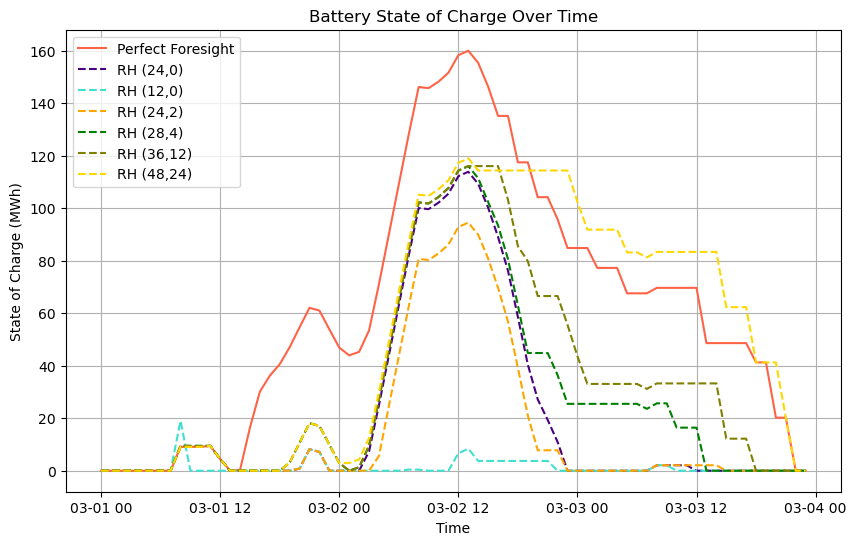

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))

for i, s in enumerate(scenario_names):
    ax.plot(
        results[s].snapshots,
        results[s].storage_units_t.state_of_charge.loc[results[s].snapshots],
        label=s,
        color=scenario_colors[i],
        ls="-" if i == 0 else "--"
    )

ax.legend(loc="upper left")
ax.set_title("Battery State of Charge Over Time")
ax.set_xlabel("Time")
ax.set_ylabel("State of Charge (MWh)")
ax.grid(True)
plt.show()


The limited foresight leads to suboptimal operational decisions, resulting in additional system costs compared to the perfect foresight case. 

In [15]:
opex_comparison = pd.concat([results[s].statistics.opex() for s in scenario_names], axis=1)
opex_comparison.columns = scenario_names
opex_comparison_diff = round((opex_comparison - results["Perfect Foresight"].statistics.opex().iloc[0]) / 1e3, 2)
opex_comparison_diff

,,Perfect Foresight,"RH (24,0)","RH (12,0)","RH (24,2)","RH (28,4)","RH (36,12)","RH (48,24)"
component,carrier,,,,,,,
Generator,grid,0.0,7.98,24.37,10.74,6.26,6.26,6.26


The rolling horizon approach is particularly useful for sequential model training, where updated forecasts are incorporated at each step. This allows the model to adapt dynamically to new information, better reflecting real-world uncertainty in variables like weather and demand.

Additionally, rolling horizon optimization helps manage computational complexity by breaking a large problem into smaller, overlapping time windows solved iteratively. This makes it possible to optimize extensive systems without overwhelming computational resources, while maintaining consistency between steps.